In [23]:
import numpy as np
from scipy import misc
import pprint as pp
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.models import load_model

from keras.losses import hinge
from keras import backend as Keras

from sklearn import metrics

In [2]:
CAFFE_ROOT = '/home/albert/caffe/'
img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')

In [3]:
train_files = {}
train_arr = []
labels = []

for f in img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if not any(idt == l for l in labels):
            labels.append(idt)
            train_files[idt] = []
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        train_files[idt].append(path)
        train_arr.append([path, idt])

labels.sort()

In [4]:
idt = 2
sample_choice = np.random.choice(range(len(train_files[idt])), np.minimum(2, len(train_files[idt])), replace=False)
print(sample_choice)

[34 10]


In [5]:
def pos_pair_generator(train_files=train_files, labels=labels):
    while True:
        idt = np.random.choice(labels, 1, replace=False)[0]
        sample_choice = np.random.choice(range(len(train_files[idt])), np.minimum(2, len(train_files[idt])), replace=False)
        pair = [misc.imread(train_files[idt][p]).tolist() for p in sample_choice]
        yield(np.array(pair).astype(np.uint8))

In [6]:
pos_generator = pos_pair_generator()

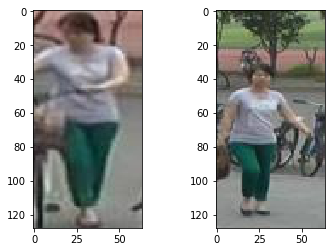

In [7]:
pos_pair = pos_generator.next()
plt.subplot(1,2,1)
plt.imshow(pos_pair[0])
plt.subplot(1,2,2)
plt.imshow(pos_pair[1])
plt.show()

In [8]:
def neg_pair_generator(train_files=train_files, labels=labels):
    while True:
        idt_choice = np.random.choice(labels, 2, replace=False)
        pair = []
        for idt in idt_choice:
            sample = np.random.choice(range(len(train_files[idt])), 1, replace=False)[0]
            pair.append(misc.imread(train_files[idt][sample]).tolist())
        yield(np.array(pair).astype(np.uint8))

In [9]:
neg_generator = neg_pair_generator()

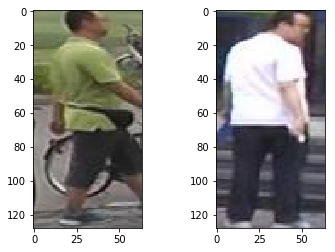

In [10]:
neg_pair = neg_generator.next()
plt.subplot(1,2,1)
plt.imshow(neg_pair[0])
plt.subplot(1,2,2)
plt.imshow(neg_pair[1])
plt.show()

In [11]:
def l2(x1, x2):
    l2 = np.sqrt(np.sum(np.power(x1 - x2, 2)))
    return l2

In [12]:
def evaluate(model, generator, n_pairs=200):
    distances = []
    for t in range(n_pairs):
        pair = generator.next()   
        predict = [model.predict(pair[i].reshape(1,128,64,3)) for i in range(2)]
#         print predict
        dist = l2(predict[0], predict[1])
        distances.append(dist)
    return distances

In [13]:
def log1p(x):
    return Keras.log(1 + Keras.exp(x))

def dist(x1, x2):
    return Keras.sum(Keras.abs(x1 - x2))

P_param = 4
K_param = 4

def triplet_loss(y_true, y_pred, margin=0.1, P=P_param, K=K_param, output_dim = 128):
    embeddings = Keras.reshape(y_pred, (-1, output_dim))

    loss = tf.Variable(1, dtype=tf.float32)

    for i in range(P):
        for a in range(K):
            pred_anchor = embeddings[i*K + a]
            hard_pos = Keras.max(dist(pred_anchor, embeddings[i*K:(i + 1)*K]))
            hard_neg = Keras.min(dist(pred_anchor, Keras.concatenate([embeddings[0:i*K],
                                                                      embeddings[(i + 1)*K:]], 0)))
            loss += log1p(hard_pos - hard_neg)
    return loss

In [14]:
# DenseNet triplet: densenet_triplet_100.h5
model = load_model('/home/albert/github/tensorflow/test_triplet_15k_margin_1.0.h5', 
                   custom_objects={'triplet_loss':triplet_loss})

# DenseNet hinge: densenet_classifier_50_hinge.h5
# base_model = load_model('/home/albert/github/tensorflow/densenet_classifier_50_hinge.h5')
# layer_name = 'dense_2'
# model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

# DenseNet cross entropy: densenet_classifier_5000_cross_entropy.h5
# base_model = load_model('/home/albert/github/tensorflow/densenet_classifier_5000_cross_entropy.h5')
# layer_name = 'dense_2'
# model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

In [15]:
pos_distance = evaluate(model, pos_generator)

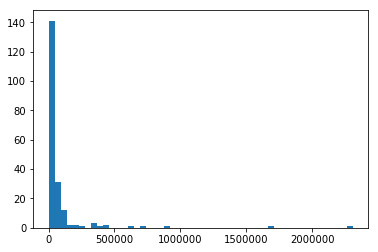

In [16]:
plt.hist(pos_distance, bins=50)
plt.show()

In [17]:
neg_distance = evaluate(model, neg_generator)

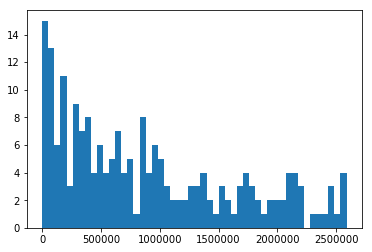

In [18]:
plt.hist(neg_distance, bins=50)
plt.show()

In [19]:
print(np.mean(np.array(pos_distance)))
print(np.mean(np.array(neg_distance)))

75366.0
892941.0


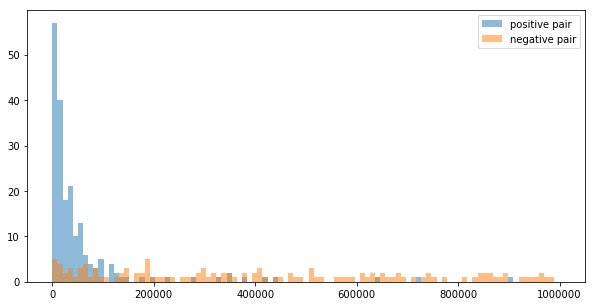

In [22]:
bins = np.linspace(0, 1000000, 100)

plt.figure(figsize=(10,5))
plt.hist(pos_distance, bins, alpha=0.5, label='positive pair')
plt.hist(neg_distance, bins, alpha=0.5, label='negative pair')
plt.legend(loc='upper right')
plt.show()

In [23]:
np.save('/home/albert/github/tensorflow/data/trinet_15k_margin_1.0_performance_pos.npy', pos_distance)
np.save('/home/albert/github/tensorflow/data/trinet_15k_margin_1.0_performance_neg.npy', neg_distance)

In [10]:
openpose_root = '/Users/tradergllc/openpose/'
pos_distance = np.load(openpose_root + 'tensorflow/data/trinet_15k_margin_1.0_performance_pos.npy')
neg_distance = np.load(openpose_root + 'tensorflow/data/trinet_15k_margin_1.0_performance_neg.npy')

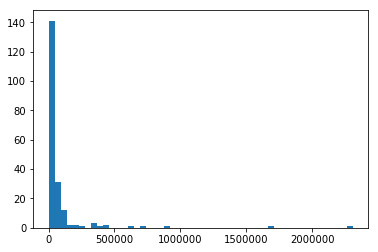

In [11]:
plt.hist(pos_distance, bins=50)
plt.show()

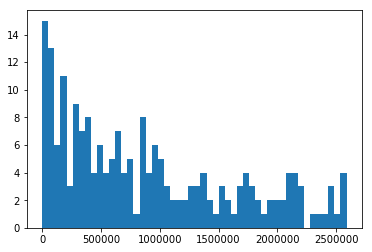

In [12]:
plt.hist(neg_distance, bins=50)
plt.show()

In [13]:
print np.mean(pos_distance)
print np.mean(neg_distance)

75366.0
892941.0


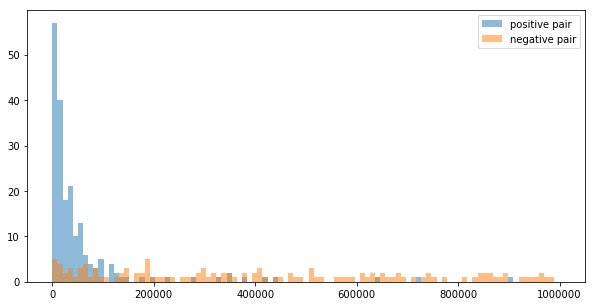

In [15]:
bins = np.linspace(0, 1000000, 100)

plt.figure(figsize=(10,5))
plt.hist(pos_distance, bins, alpha=0.5, label='positive pair')
plt.hist(neg_distance, bins, alpha=0.5, label='negative pair')
plt.legend(loc='upper right')
plt.show()

In [38]:
precision = []
recall = []
for thresh in range(10000, 500000, 10000):
    true = np.ones(len(pos_distance)).tolist() + np.zeros(len(neg_distance)).tolist()
    pred_pos = [int(d < thresh) for d in pos_distance]
    pred_neg = [int(d < thresh) for d in neg_distance]
    pred = pred_pos + pred_neg

    precision.append(metrics.precision_score(true, pred))
    recall.append(metrics.recall_score(true, pred))

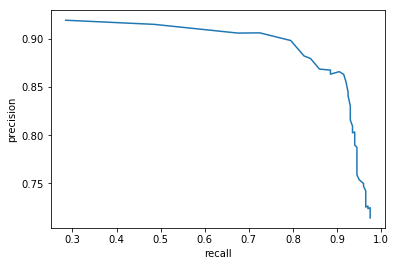

In [39]:
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')